# COVID-19-International - Last 60 Days Daily Evolution  

<div style="float:right; a.color: grey;">
    <a href="https://github.com/matosdotnet">
        <img src="https://avatars3.githubusercontent.com/u/64945038?s=60&v=4">
        matosdotnet
    </a>
</div>

<ul> 
        <li>New Cases</li>
        <li>New Deaths</li>
        <li>New Suspects</li>
        <li>New Recovered</li>
      </ul>
       Data Source: 
        <a href="https://github.com/CSSEGISandData/COVID-19">https://github.com/CSSEGISandData/COVID-19</a>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import datetime
%matplotlib inline

# Define the last number of days here
nr_last_days = 60
s_title = 'COVID-19 International'
s_url_confirmations = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
s_url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
s_url_recoveries = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
s_local_snapshot_path = 'data-int.csv'

In [2]:
#define dictionaries with metadata
d_confirmations = {'key' : 'confirmations', 'label' : 'Cases', 'color' : '#00D0FE'}
d_new_confirmations = {'key' : 'confirmations_new', 'label' : 'New Cases', 'color' : '#00D0FE'}

d_deaths = {'key' : 'deaths', 'label' : 'Deaths', 'color' : '#FE0004'}
d_new_deaths = {'key' : 'deaths_new', 'label' : 'New Deaths', 'color' : '#FE0004'}

#d_suspects = {'key' : 'suspects', 'label' : 'Suspects', 'color' : '#FE6C00'}
#d_new_suspects = {'key' : 'suspects_new', 'label' : 'New Suspects', 'color' : '#FE6C00'}

d_recoveries = {'key' : 'recoveries', 'label' : 'Recoveries', 'color' : '#7FFE00'}
d_new_recoveries = {'key' : 'recoveries_new', 'label' : 'New Recoveries', 'color' : '#7FFE00'}

d_active = {'key' : 'active', 'label' : 'Active', 'color' : '#FE0004'}
d_new_active = {'key' : 'active_new', 'label' : 'New Active', 'color' : '#FE00F6'}

#d_icu = {'key' : 'internados_uci', 'label' : 'ICU Patients', 'color' : '#FEFE00'}
#d_new_icu = {'key' : 'internados_uci_novos', 'label' : 'New ICU Patients', 'color' : '#FEFE00'}

In [3]:
def read_data_remote():
    # Read Source Data
    df_confirmations = pd.read_csv(s_url_confirmations)
    df_deaths = pd.read_csv(s_url_deaths)
    df_recoveries = pd.read_csv(s_url_recoveries)
    #transform
    

    df_confirmations = df_confirmations.melt(id_vars=df_confirmations.columns[:4],var_name='date',value_name=d_confirmations['key'])
    df_deaths = df_deaths.melt(id_vars=df_deaths.columns[:4],var_name='date',value_name=d_deaths['key'])
    df_recoveries = df_recoveries.melt(id_vars=df_recoveries.columns[:4],var_name='date',value_name=d_recoveries['key'])
    
    
    
    #merge
    df_full = pd.merge(df_confirmations,df_deaths,how='outer',on=['Province/State','Country/Region','Lat','Long','date'])
    df_full = df_full.merge(df_recoveries,how='outer',on=['Province/State','Country/Region','Lat','Long','date'])
    
    df_full['id'] = df_full[['Province/State','Country/Region','Lat','Long']].apply(lambda x : '{}_{}_{}_{}'.format(
                                                                                                x['Province/State']
                                                                                               ,x['Country/Region']
                                                                                               ,x['Lat'],x['Long']
                                                                                               ),axis=1)   
    # Manage Dates Formating
    df_full['date'] = df_full['date'].apply(lambda x : pd.to_datetime(x,format='%m/%d/%y'))
    
    # New Confirmations, Deaths, Recoveries, Active
    df_full[d_active['key']] = df_full[d_confirmations['key']] - df_full[d_recoveries['key']]- df_full[d_deaths['key']]
    
    df_full = df_full.sort_values(by=['id', 'date'])
    df_full[[d_new_confirmations['key'], d_new_deaths['key'],d_new_recoveries['key'],d_new_active['key']]] = df_full.groupby(['id'])[[d_confirmations['key'], d_deaths['key'],d_recoveries['key'],d_active['key']]].diff().fillna(0)
    #Set Index
    df_full = df_full.set_index(['date'])
    
    #Fill Null values
    df_full.fillna(value=0, inplace=True)
    #save locally
    df_full.to_csv(s_local_snapshot_path)
    return df_full

def read_data_local() :  
    df_full = pd.read_csv(s_local_snapshot_path)
    df_full['date'] = df_full['date'].apply(lambda x : pd.to_datetime(x))
    df_full = df_full.set_index(['date'])
    return df_full 

def read_data() :
    df_full = pd.DataFrame()
    try:
        df_full = read_data_remote()
    except:
        df_full = read_data_local()
        print("An exception occurred reading data from \n{}\n{}\n{}\nAlternatively the latest Snapshot from {} was retrieved.".format(s_url_confirmations,s_url_deaths,s_url_recoveries,df_full.index.max()))
    else:
         print("Data collected sucessfully from:\n{}\n{}\n{}".format(s_url_confirmations,s_url_deaths,s_url_recoveries))
    return df_full

def get_country_df(country_name,df = pd.DataFrame()):   
    df_country = df[df['Country/Region']==country_name].reset_index().groupby(['date','Country/Region']).sum()
    df_country = df_country.reset_index()
    df_country = df_country.set_index('date')
    return df_country

In [4]:
#Read Data
#df_full  = read_data()
df_full  = read_data_local()
# Slices
df_latest = get_country_df('Portugal',df_full).tail(nr_last_days)

In [5]:
#df_full.fillna(value=0, inplace=True)
df_latest.tail()

,Country/Region,Lat,Long,confirmations,deaths,recoveries,active,confirmations_new,deaths_new,recoveries_new,active_new
date,,,,,,,,,,,
2020-05-21,Portugal,39.3999,-8.2245,29912.0,1277.0,6452.0,22183.0,252.0,14.0,0.0,238.0
2020-05-22,Portugal,39.3999,-8.2245,30200.0,1289.0,7590.0,21321.0,288.0,12.0,1138.0,-862.0
2020-05-23,Portugal,39.3999,-8.2245,30471.0,1302.0,7705.0,21464.0,271.0,13.0,115.0,143.0
2020-05-24,Portugal,39.3999,-8.2245,30623.0,1316.0,17549.0,11758.0,152.0,14.0,9844.0,-9706.0
2020-05-25,Portugal,39.3999,-8.2245,30788.0,1330.0,17822.0,11636.0,165.0,14.0,273.0,-122.0


In [6]:
df_latest[[d_confirmations['key'],d_new_confirmations['key'],d_deaths['key'],d_new_deaths['key'],d_recoveries['key'],d_new_recoveries['key'],d_new_active['key']]].tail(1)

,confirmations,confirmations_new,deaths,deaths_new,recoveries,recoveries_new,active_new
date,,,,,,,
2020-05-25,30788.0,165.0,1330.0,14.0,17822.0,273.0,-122.0


In [7]:
# Last X count days overall description
df_latest[[d_new_confirmations['key'],d_new_deaths['key'],d_new_recoveries['key'],d_new_active['key']]].describe()

,confirmations_new,deaths_new,recoveries_new,active_new
count,60.000000,60.000000,60.000000,60.000000
mean,454.066667,21.166667,296.316667,136.583333
std,289.486856,8.223914,1287.522618,1369.745384
min,-161.000000,6.000000,0.000000,-9706.000000
25%,225.250000,14.750000,8.500000,124.250000
50%,449.000000,20.000000,32.500000,326.500000
75%,646.500000,27.250000,118.250000,583.750000
max,1516.000000,37.000000,9844.000000,1462.000000


In [8]:
def line_plot_df_tindex(y,data,title,ylabel,ycolor,num_rolling_days=7):
    #Set Style
    sns.set_style('darkgrid', 
              {
                  'axes.facecolor': '#646666',
                  'figure.facecolor': '#646666',
                  'grid.color': 'lightgrey',
                  'grid.linestyle': 'dotted',
                  'xtick.color': 'white',
                  'xtick.top': False,
                  'xtick.bottom': True,
                  'ytick.color': 'white',
                  'ytick.left': True,
                  'ytick.right': False,
                  'axes.labelcolor': 'white',
                  'axes.spines.top': False,
                  'axes.spines.right': False,
                  'text.color': 'white'
                  
              })

    #Set Fig Size
    fig = plt.figure(figsize=(12,5))

    #Line Plot with mean
    v_mean = data[y].mean()
    v_df_moving_averages = data[y].rolling(window=num_rolling_days).mean()
 
    ax = sns.lineplot(x=data.index,y=v_df_moving_averages
                      ,color = '#5CFE00'
                      ,alpha = 0.2        
                      ,dashes=True
                     # ,estimator = 'mean'
                     )
    
    #Line Plots with Standard Deviation
    v_df_moving_upper_stds = v_df_moving_averages + 2*data[y].rolling(window=num_rolling_days).std()
    v_df_moving_lower_stds = v_df_moving_averages - 2*data[y].rolling(window=num_rolling_days).std()
    
    v_std =  data[y].std()

    ax = sns.lineplot(x=data.index,y=v_df_moving_upper_stds
                      ,color = '#5CFE00'
                      ,alpha = 0.2        
                      ,dashes=True
                     # ,estimator = 'mean'
                     )
    
    ax.lines[1].set_linestyle('dotted')
    
    ax = sns.lineplot(x=data.index,y=v_df_moving_lower_stds
                      ,color = '#5CFE00'
                      ,alpha = 0.2        
                      ,dashes=True
                     # ,estimator = 'mean'
                     )
    ax.lines[2].set_linestyle('dotted')
    
    #Line Plot with data

    ax = sns.lineplot(x=data.index,y=data[y]
                      ,marker=True
                      ,markers=["o", "o"]
                      ,alpha = 0.5
                      ,dashes=False
                      ,style=True
                      ,hue = 1
                      ,palette = [ycolor]
                     # ,estimator = 'mean'
                     )

    # Rerieve Max, Min and Latest
    y_max = data[y].max()
    x_max = data[[y]].idxmax()[0]
    y_min = data[y].min()
    x_min = data[[y]].idxmin()[0]
    y_mean = y_max+y_max*0.10
    x_mean = data[[y]].index[0]
    x_latest =  data.index.max()
    y_latest = data[x_latest:x_latest][y][0]

    # Slice the chart canvas
    ax.set_xlim(data.index.min(), data.index.max()+datetime.timedelta(days=1))
      
    if y_min >= 0 :
        ax.set_ylim(0, y_max+y_max*0.10)
    else :
        ax.set_ylim(y_min+y_min*0.10, y_max+y_max*0.10)

    #Set Date Format
    str_date_format = '%d/%m'

    #Anotattions for Max, Min and Latest
    lbl_y_offset = 0.02*y_max
    lbl_y_max_offset = 0.02*y_max
    lbl_y_min_offset = 0.02*y_min

    ax.annotate('  MAX: {0:.0f} \n {1}'.format(y_max,x_max.strftime(str_date_format))
                ,xy=(x_max,y_max)
                ,xytext=(x_max,y_max+lbl_y_max_offset)
                ,ha='center')
    
    if (x_min != x_max) :
        ax.annotate('  MIN: {0:.0f} \n {1}'.format(y_min,x_min.strftime(str_date_format))
                ,xy=(x_min,y_min)
                ,xytext=(x_min,y_min+lbl_y_min_offset)
                ,ha='center')

    if (x_latest != x_max) and (x_latest!= x_min) :
        ax.annotate('  {0:.0f} \n {1}'.format(y_latest,x_latest.strftime(str_date_format))
                ,xy=(x_latest,y_latest)
                ,xytext=(x_latest,y_latest+lbl_y_offset)
                ,ha='center')
    
    plt.figtext(0.1, 0.05,'x̄: {0:.1f} σ: {1:.1f} : Rolling[x̄ +- 2σ] N={2:.0f}'.format(v_mean,v_std,num_rolling_days)
               #,ha='right'
               ,color='#5CFE00') 
    
    #Axis and Labels formating
    ax.set_title(title)
    
    #Make sure the dataset has continuous dates in the DataFrame
    ax.set_xlabel('Last {0} days'.format(len(data.index)))
    ax.set_ylabel(ylabel)

    myFmt = mdates.DateFormatter(str_date_format)
    ax.xaxis.set_major_formatter(myFmt)
    ax.legend().remove()

    # Fill Area
    plt.fill_between( data.index, data[y], color=ycolor, alpha=0.2)
    
    #fig.savefig("{}.png".format(title),bbox_inches = 'tight', dpi=plt.gcf().dpi,facecolor='#646666')
    fig.savefig("{}.png".format(title),bbox_inches = 'tight', dpi=300,facecolor='#646666')
    
    plt.show()

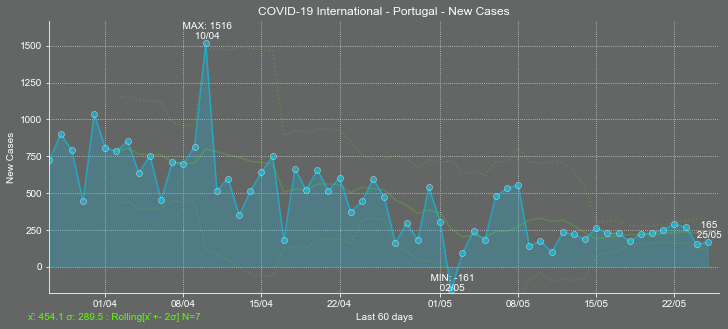

In [9]:
#from MatosDotNetStandardCharts import line_plot_df_tindex 
line_plot_df_tindex(
                d_new_confirmations['key']
                ,data=df_latest
                ,title='{} - {} - {}'.format(s_title,df_latest['Country/Region'].unique()[0],d_new_confirmations['label'])
                ,ylabel=d_new_confirmations['label']
                ,ycolor=d_new_confirmations['color']
               )

In [10]:
# Trace outstanding vales
df_latest[[d_confirmations['key'],d_new_confirmations['key']]]['2020-04-09':'2020-04-11']

,confirmations,confirmations_new
date,,
2020-04-09,13956.0,815.0
2020-04-10,15472.0,1516.0
2020-04-11,15987.0,515.0


<a href="https://covid19.min-saude.pt/wp-content/uploads/2020/04/39_DGS_boletim_20200410.pdf">Relatório de Situação nº 039 | 10/04/2020</a>
<br/>
    <a href="https://www.publico.pt/2020/04/10/sociedade/noticia/covid19-ha-26-mortes-1516-infectados-portugal-1911826">Covid-19: há mais 26 mortes e mais 1516 infectados em Portugal<a/>
    <br/>
    <a href="https://www.jornaldenegocios.pt/economia/coronavirus/detalhe/morreram-mais-26-pessoas-em-portugal-com-covid-19-e-casos-confirmados-aumentam-mais-de-10">Morreram mais 26 pessoas em Portugal com covid-19 e casos confirmados aumentam mais de 10%</a>

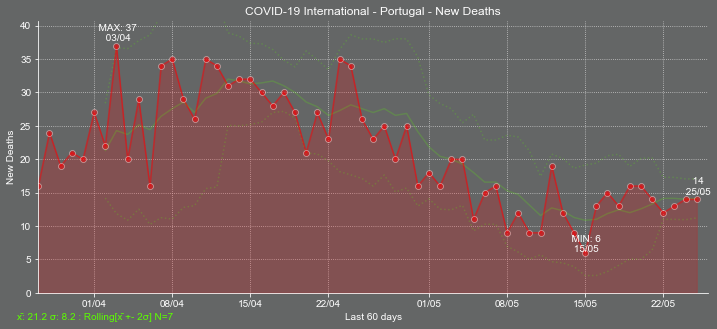

In [11]:
line_plot_df_tindex(
                d_new_deaths['key']
                ,data=df_latest
                ,title='{} - {} - {}'.format(s_title,df_latest['Country/Region'].unique()[0],d_new_deaths['label'])
                ,ylabel=d_new_deaths['label']
                ,ycolor=d_new_deaths['color']
               )

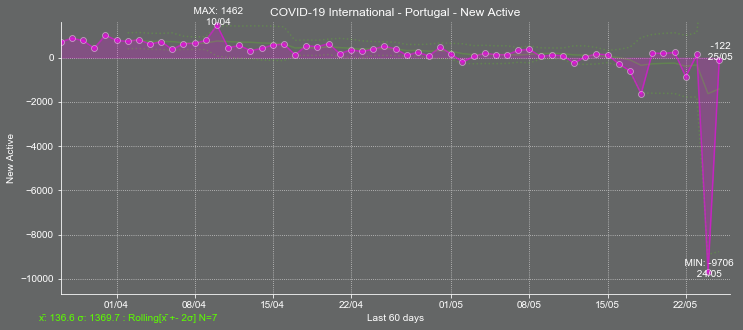

In [12]:
line_plot_df_tindex(
                d_new_active['key']
                ,data=df_latest
                ,title='{} - {} - {}'.format(s_title,df_latest['Country/Region'].unique()[0],d_new_active['label'])
                ,ylabel=d_new_active['label']
                ,ycolor=d_new_active['color']
               )

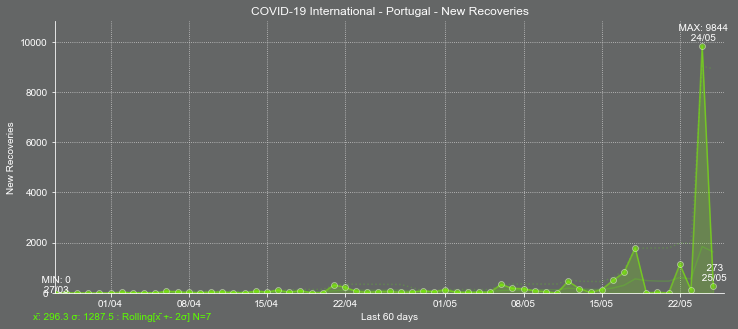

In [13]:
line_plot_df_tindex(
                d_new_recoveries['key']
                ,data=df_latest
                ,title='{} - {} - {}'.format(s_title,df_latest['Country/Region'].unique()[0],d_new_recoveries['label'])
                ,ylabel=d_new_recoveries['label']
                ,ycolor=d_new_recoveries['color']
               )

In [14]:
# Trace outstanding vales
df_latest[[d_recoveries['key'],d_new_recoveries['key']]]['2020-05-17':'2020-05-24']

,recoveries,recoveries_new
date,,
2020-05-17,4636.0,814.0
2020-05-18,6430.0,1794.0
2020-05-19,6431.0,1.0
2020-05-20,6452.0,21.0
2020-05-21,6452.0,0.0
2020-05-22,7590.0,1138.0
2020-05-23,7705.0,115.0
2020-05-24,17549.0,9844.0


<a href="https://covid19.min-saude.pt/wp-content/uploads/2020/05/83_DGS_boletim_20200524.pdf">Relatório de Situação nº 083 | 24/05/2020</a>
<br/>
<a href="https://rr.sapo.pt/2020/05/24/pais/balanco-dgs-quase-10-mil-novas-recuperacoes-num-dia/noticia/194014/">Balanço DGS. Quase 10 mil novas recuperações num dia<a/>


<a href="https://covid19.min-saude.pt/wp-content/uploads/2020/05/77_DGS_boletim_20200518.pdf">Relatório de Situação nº 077 | 18/05/2020</a>
<br/>
<a href="https://www.rtp.pt/noticias/pais/forte-subida-de-recuperados-deve-se-as-instituicoes-reportarem-mais-dgs_n1229822">Forte subida de recuperados deve-se às instituições reportarem mais - DGS<a/>

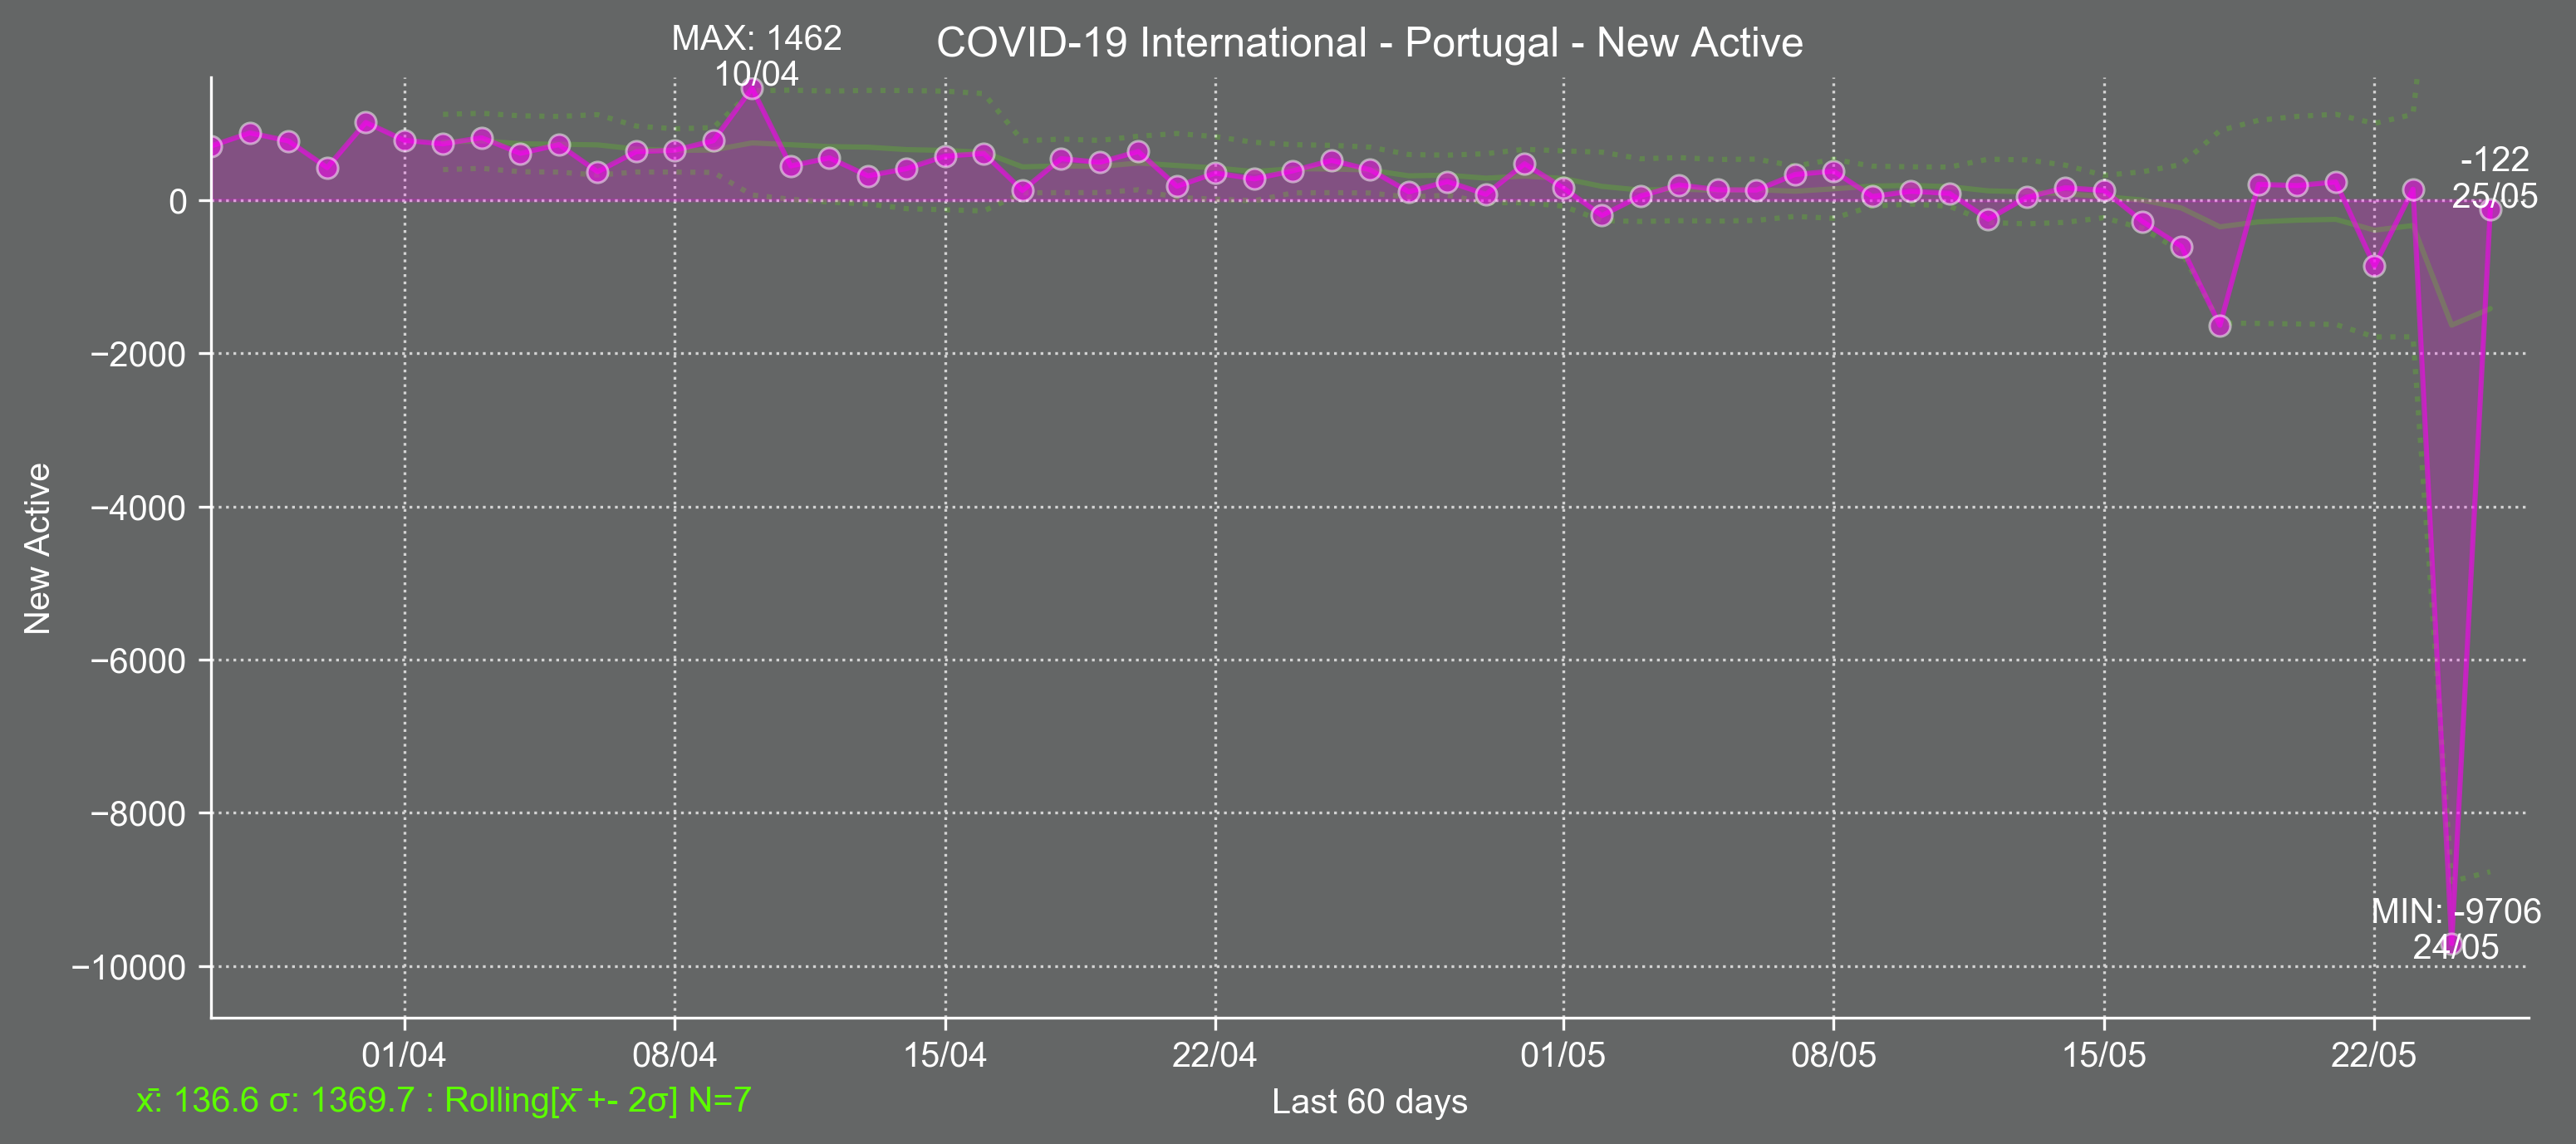

COVID-19 International - Portugal - New Active.png


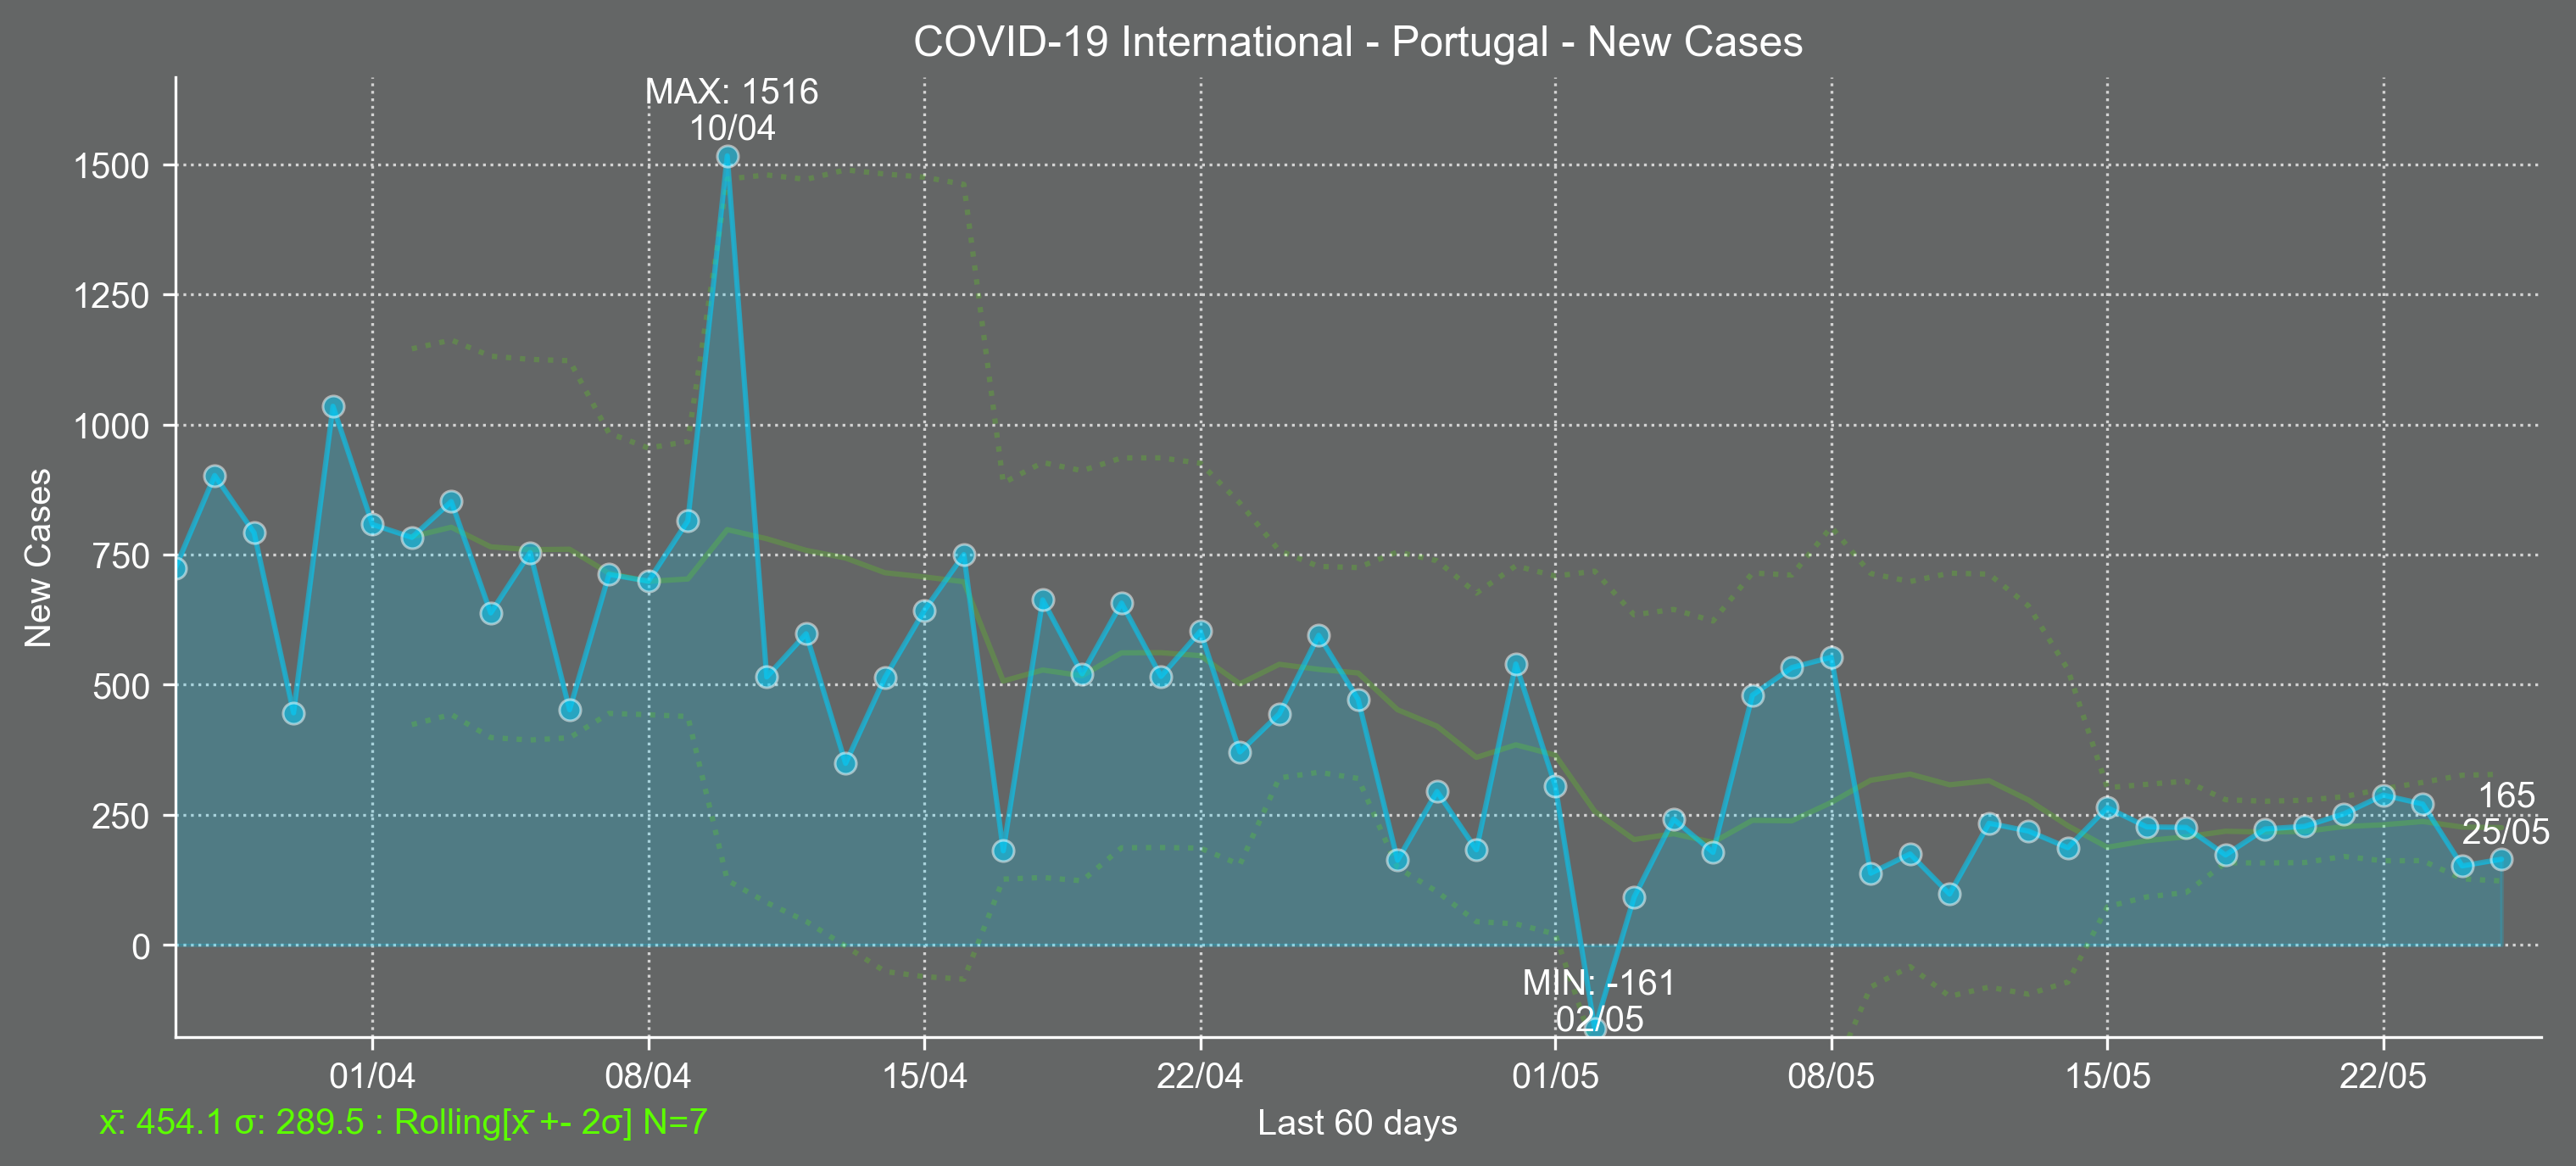

COVID-19 International - Portugal - New Cases.png


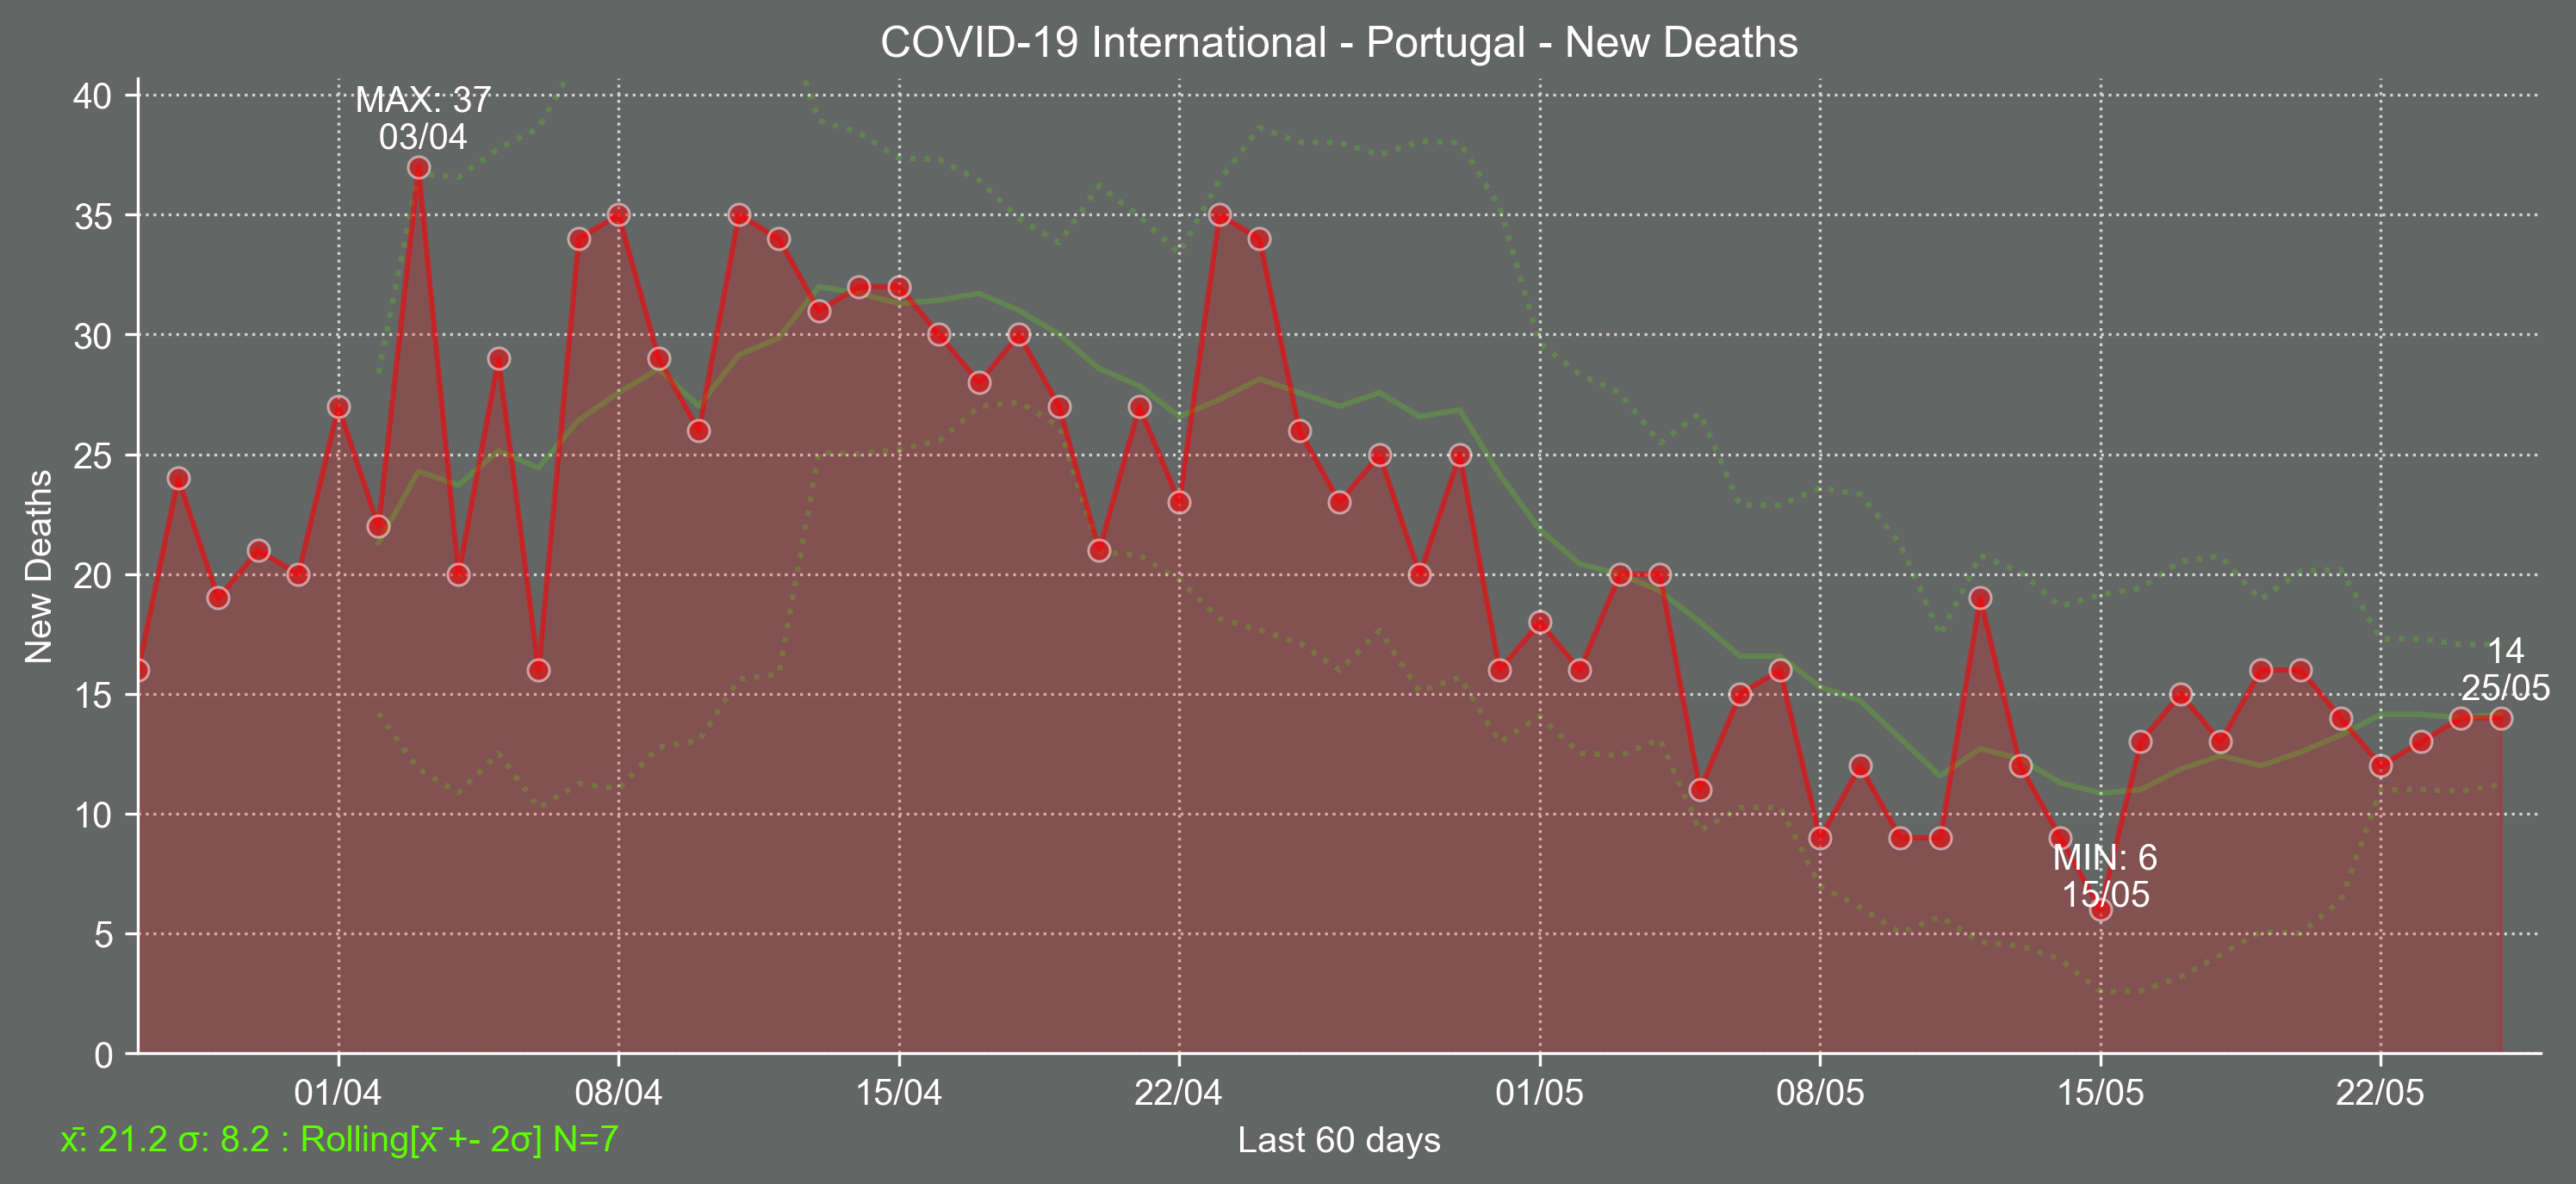

COVID-19 International - Portugal - New Deaths.png


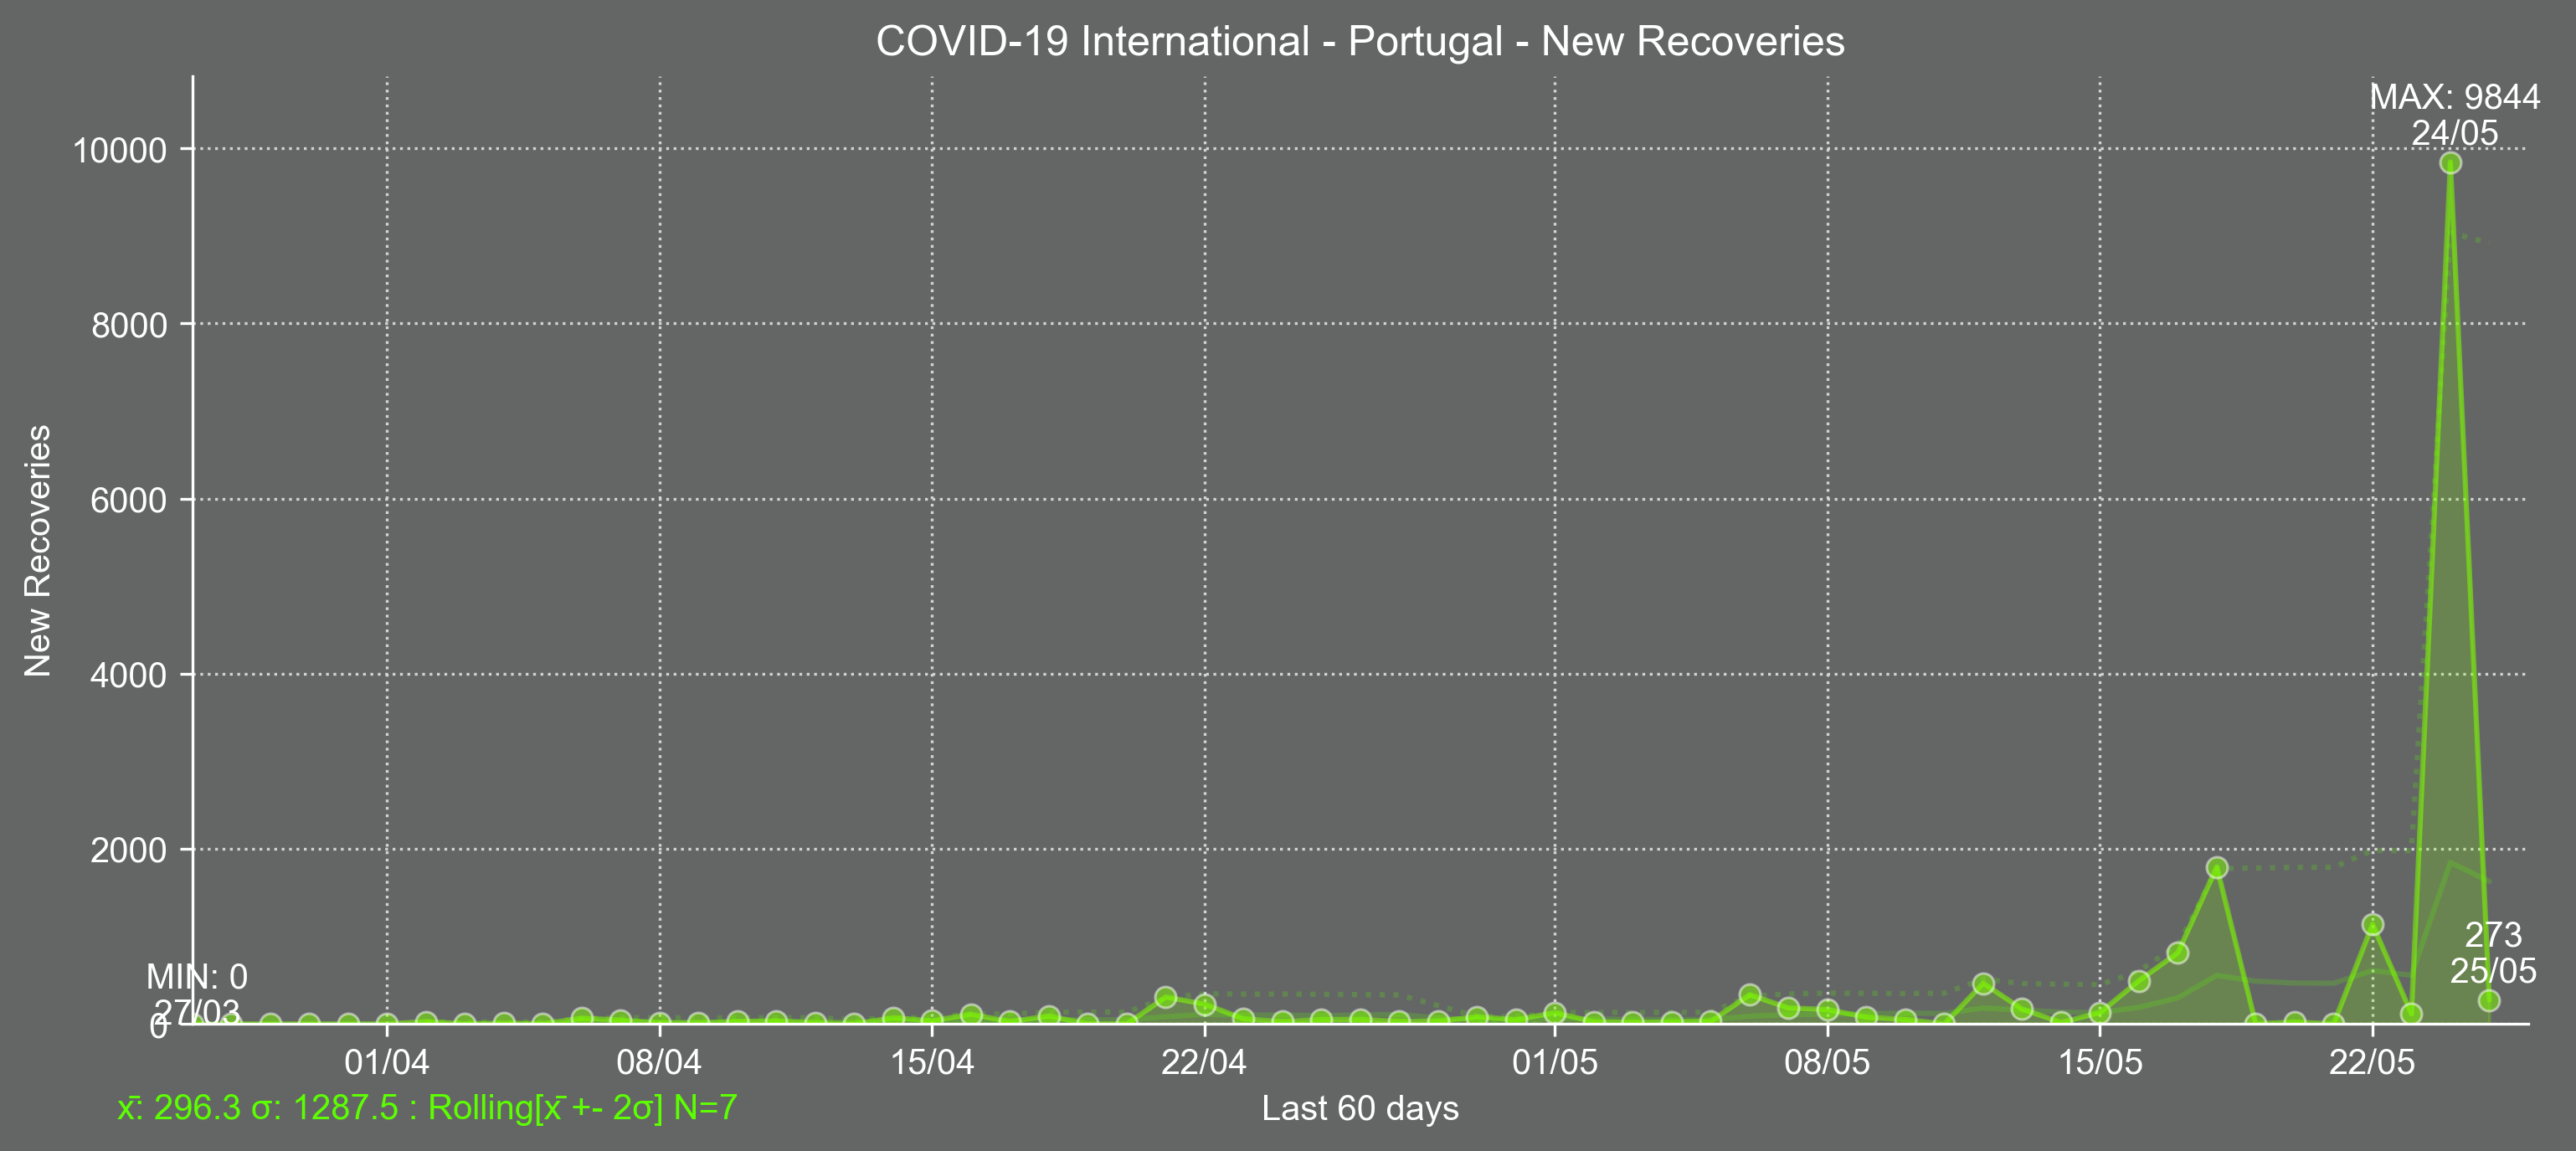

COVID-19 International - Portugal - New Recoveries.png


In [15]:
# Show saved chart images with 300 dpi
import glob
from IPython.display import Image, display
for imageName in glob.glob('{}*.png'.format(s_title)): 
    display(Image(filename=imageName))
    print(imageName)

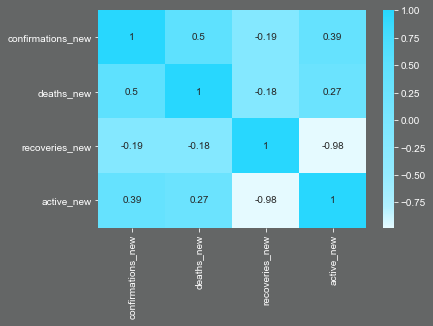

In [16]:
#Check correlation
from matplotlib.colors import LinearSegmentedColormap

boundaries = [0.0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]  
hex_colors = sns.light_palette(d_confirmations['color'], n_colors=len(boundaries) * 2 + 2, as_cmap=False).as_hex()
hex_colors = [hex_colors[i] for i in range(0, len(hex_colors), 2)]
colors=list(zip(boundaries, hex_colors))
custom_color_map = LinearSegmentedColormap.from_list(
    name='custom_navy',
    colors=colors,
)

df_latest_corr = df_latest[[d_new_confirmations['key'],d_new_deaths['key'],d_new_recoveries['key'],d_new_active['key']]].corr()
sns.heatmap(df_latest_corr,annot=True,cmap=custom_color_map)

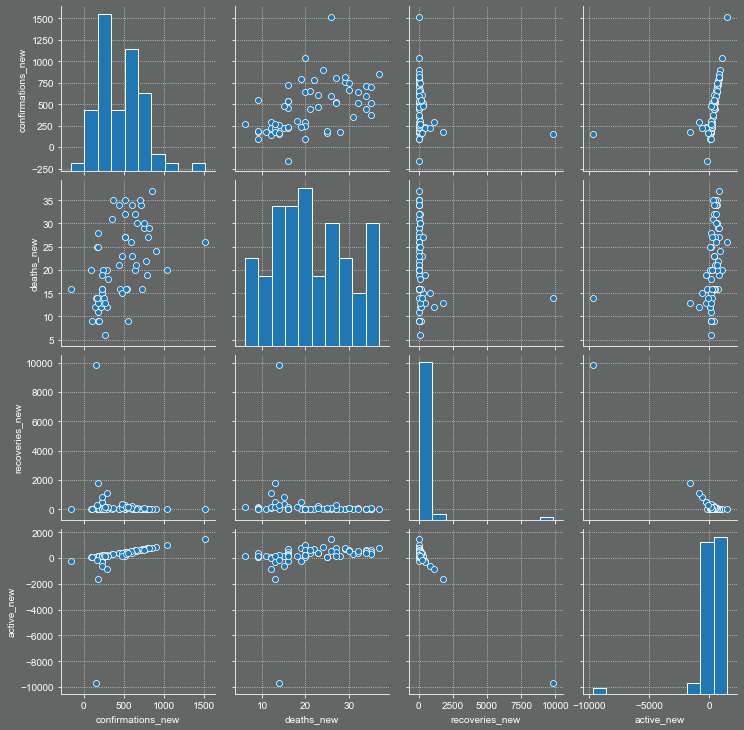

In [17]:
sns.pairplot(df_latest[[d_new_confirmations['key'],d_new_deaths['key'],d_new_recoveries['key'],d_new_active['key']]])